In [ ]:
#T4 GPU

# Task 1

Note that the AlexNet implementation here does not have the local response normalization feature described in the paper. Take a look at the PyTorch implementation of LRN and incorporate it into your AlexNet implementation as it is described in the paper. Compare your test set results with and without LRN.

Import Necessary Library

In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt

Prepare for data processing

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

Splitting dataset

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [10000, 40000])
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [5000, 5000])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 170498071/170498071 [00:02<00:00, 77445750.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


AlexNet Module

In [ ]:
class AlexNetModule(nn.Module):
    def __init__(self, num_classes, lrn=False):
        super().__init__()
        self.num_classes = num_classes
        #local response norm
        self.lrn = lrn

        # Features layer
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Classifier layer
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)

        if self.lrn:
            # Apply LRN if enabled
            x = F.local_response_norm(x, size=5, alpha=1e-4, beta=0.75, k=2)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Model Initiation

In [ ]:
#alexnet with local response normalization
alexnet_module_with_lrn = AlexNetModule(10, lrn=True)
alexnet_module_with_lrn = alexnet_module_with_lrn.to(device)

#alexnet without local response normalization
alexnet_module_without_lrn = AlexNetModule(10, lrn=False)
alexnet_module_without_lrn = alexnet_module_without_lrn.to(device)

Define loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_with_lrn = optim.SGD(alexnet_module_with_lrn.parameters(), lr=0.001, momentum=0.9)
optimizer_without_lrn = optim.SGD(alexnet_module_without_lrn.parameters(), lr=0.001, momentum=0.9)

Create train model function

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print(f'Epoch {epoch}/{num_epochs - 1}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    preds = torch.argmax(outputs, dim=1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.item() / len(dataloaders[phase].dataset)
            epoch_end = time.time()

            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

Create test model function

In [ ]:
def test_model(model, test_dataloader):
    model.eval()
    corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            corrects += (predicted == labels).sum().item()

    accuracy = corrects / total
    print('Test Accuracy: {:.4f}'.format(accuracy))

Model Training

In [ ]:
# Train and test the model with LRN
dataloaders = {'train': train_dataloader, 'val': val_dataloader}
best_model_with_lrn, val_acc_history_with_lrn, loss_acc_history_with_lrn = train_model(
    alexnet_module_with_lrn, dataloaders, criterion, optimizer_with_lrn, 10)

Epoch 0/9
train Loss: 2.3026 Acc: 0.1046
Epoch time taken:  19.16561532020569
val Loss: 2.3027 Acc: 0.0978
Epoch time taken:  28.116887092590332
Epoch 1/9
train Loss: 2.3024 Acc: 0.1048
Epoch time taken:  11.744606733322144
val Loss: 2.3027 Acc: 0.0978
Epoch time taken:  21.366470336914062
Epoch 2/9
train Loss: 2.3022 Acc: 0.1048
Epoch time taken:  11.499810695648193
val Loss: 2.3027 Acc: 0.0978
Epoch time taken:  20.64176106452942
Epoch 3/9
train Loss: 2.3020 Acc: 0.1052
Epoch time taken:  11.616498231887817
val Loss: 2.3027 Acc: 0.0978
Epoch time taken:  21.187718152999878
Epoch 4/9
train Loss: 2.3019 Acc: 0.1048
Epoch time taken:  11.55506420135498
val Loss: 2.3027 Acc: 0.1198
Epoch time taken:  21.157727479934692
Epoch 5/9
train Loss: 2.3018 Acc: 0.1136
Epoch time taken:  11.06530237197876
val Loss: 2.3027 Acc: 0.1044
Epoch time taken:  20.237040996551514
Epoch 6/9
train Loss: 2.3017 Acc: 0.1186
Epoch time taken:  11.656583547592163
val Loss: 2.3028 Acc: 0.0960
Epoch time taken:  2

In [ ]:
# Train and test the model without LRN
best_model_without_lrn, val_acc_history_without_lrn, loss_acc_history_without_lrn = train_model(
    alexnet_module_without_lrn, dataloaders, criterion, optimizer_without_lrn, 10)

Epoch 0/9
train Loss: 2.3027 Acc: 0.1064
Epoch time taken:  11.888379335403442
val Loss: 2.3025 Acc: 0.0994
Epoch time taken:  21.317293643951416
Epoch 1/9
train Loss: 2.3025 Acc: 0.1004
Epoch time taken:  11.493034839630127
val Loss: 2.3024 Acc: 0.0960
Epoch time taken:  20.213753938674927
Epoch 2/9
train Loss: 2.3023 Acc: 0.1076
Epoch time taken:  11.917431116104126
val Loss: 2.3025 Acc: 0.1010
Epoch time taken:  21.482059717178345
Epoch 3/9
train Loss: 2.3022 Acc: 0.1058
Epoch time taken:  11.591344594955444
val Loss: 2.3025 Acc: 0.0960
Epoch time taken:  20.61785650253296
Epoch 4/9
train Loss: 2.3020 Acc: 0.1164
Epoch time taken:  11.524513483047485
val Loss: 2.3025 Acc: 0.0960
Epoch time taken:  21.1326105594635
Epoch 5/9
train Loss: 2.3018 Acc: 0.1114
Epoch time taken:  11.484464406967163
val Loss: 2.3026 Acc: 0.0960
Epoch time taken:  20.848788261413574
Epoch 6/9
train Loss: 2.3018 Acc: 0.1060
Epoch time taken:  11.096120119094849
val Loss: 2.3026 Acc: 0.0960
Epoch time taken:  

Evaluate the model(s)

In [ ]:
test_model(alexnet_module_with_lrn, test_dataloader)
print('===performance test using local response normalization===')
test_model(alexnet_module_without_lrn, test_dataloader)
print('===performance test without local response normalization===')

Test Accuracy: 0.1208
===performance test using local response normalization===
Test Accuracy: 0.1038
===performance test without local response normalization===


Plotting learning curve/the results from the model(s)

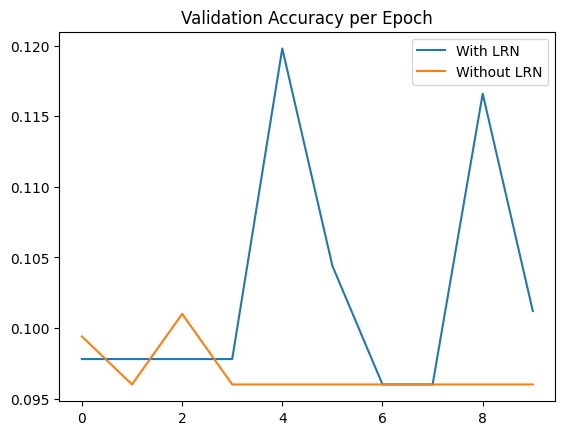

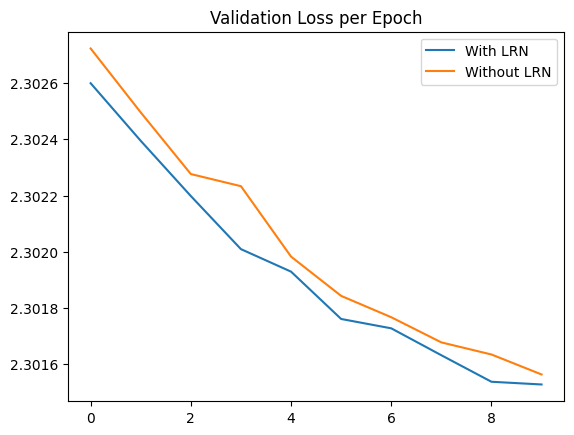

In [ ]:
plt.plot(val_acc_history_with_lrn, label='With LRN')
plt.plot(val_acc_history_without_lrn, label='Without LRN')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.show()

plt.plot(loss_acc_history_with_lrn, label='With LRN')
plt.plot(loss_acc_history_without_lrn, label='Without LRN')
plt.title('Validation Loss per Epoch')
plt.legend()
plt.show()

# Task 2

Note that the GoogLeNet implementation here does not have the auxiliary classifiers. Let's implement the GoogLeNet with auxiliary classifiers version (see Link) and compare your test set results with and without auxiliary classifiers.

Import Necessary Library

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F
from torchsummary import summary
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

Prepare for data processing

In [2]:
# Data preprocessing
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

Splitting dataset

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=preprocess)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [10000, 40000])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=preprocess)

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

dataloaders = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

100%|██████████| 170498071/170498071 [00:06<00:00, 24377744.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Check device

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

Using device cuda:0


Sample check

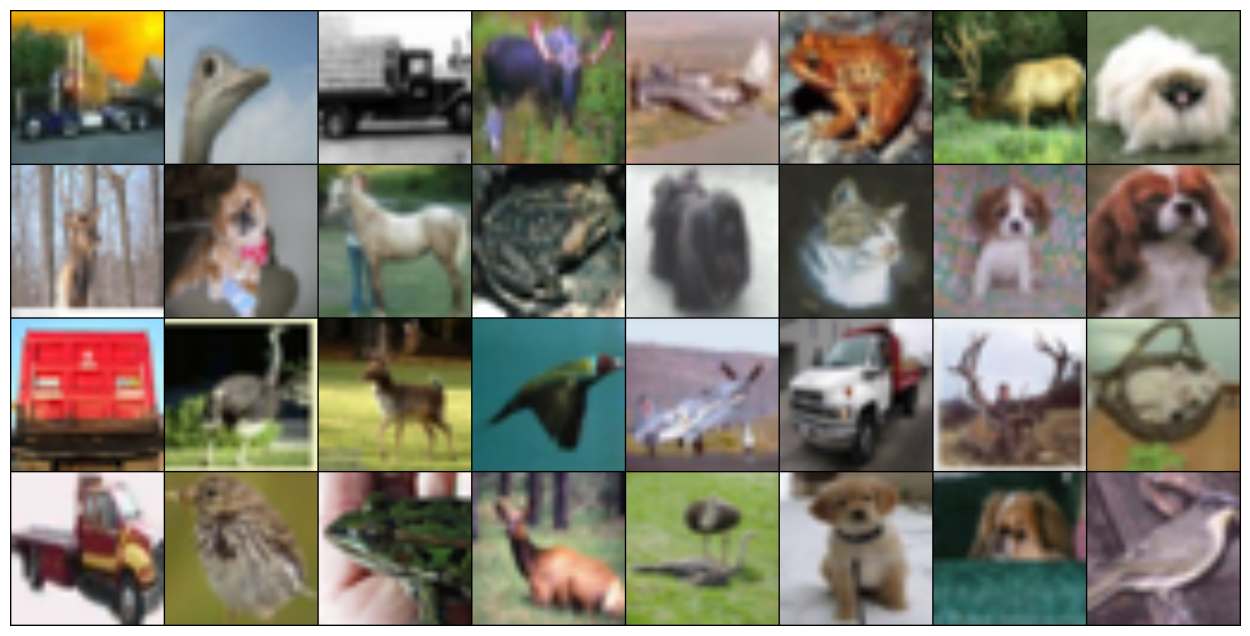

In [5]:
for images, _ in train_dataloader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

Inception Class

In [6]:
class Inception(nn.Module):

    def __init__(self, in_channels=3, use_auxiliary=True, num_classes=1000):
        super(Inception, self).__init__()

        self.conv1 = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)

        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(1024, num_classes)

        self.use_auxiliary = use_auxiliary
        if use_auxiliary:
            self.auxiliary4a = Auxiliary(512, num_classes)
            self.auxiliary4d = Auxiliary(528, num_classes)

        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

    def forward(self, x):
        y = None
        z = None

        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)

        x = self.inception4a(x)
        if self.training and self.use_auxiliary:
            y = self.auxiliary4a(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.use_auxiliary:
            z = self.auxiliary4d(x)

        x = self.inception4e(x)
        x = self.maxpool(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)

        x = self.linear(x)

        return x, y, z

Convolutional Block

In [7]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

Inception Block

In [8]:
class InceptionBlock(nn.Module):

    def __init__(self, im_channels, num_1x1, num_3x3_red, num_3x3, num_5x5_red, num_5x5, num_pool_proj):
        super(InceptionBlock, self).__init__()

        self.one_by_one = ConvBlock(im_channels, num_1x1, kernel_size=1)

        self.tree_by_three_red = ConvBlock(im_channels, num_3x3_red, kernel_size=1)
        self.tree_by_three = ConvBlock(num_3x3_red, num_3x3, kernel_size=3, padding=1)

        self.five_by_five_red = ConvBlock(im_channels, num_5x5_red, kernel_size=1)
        self.five_by_five = ConvBlock(num_5x5_red, num_5x5, kernel_size=5, padding=2)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_proj = ConvBlock(im_channels, num_pool_proj, kernel_size=1)

    def forward(self, x):
        x1 = self.one_by_one(x)

        x2 = self.tree_by_three_red(x)
        x2 = self.tree_by_three(x2)

        x3 = self.five_by_five_red(x)
        x3 = self.five_by_five(x3)

        x4 = self.maxpool(x)
        x4 = self.pool_proj(x4)

        x = torch.cat([x1, x2, x3, x4], 1)
        return x

Auxiliary Class

In [9]:
class Auxiliary(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(Auxiliary, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1x1 = ConvBlock(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.7)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1x1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Defini train model function

In [10]:
# Define a function to train the model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, use_auxiliary=True):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if use_auxiliary:
                        outputs, aux1, aux2 = model(inputs)
                        loss = criterion(outputs, labels)
                        if model.training:
                            loss += 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
                    else:
                        outputs, _, _ = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            if phase == 'val':
                lr_scheduler.step(epoch_loss)

            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Initiate model(s)

In [11]:
# Initialize the model
model = Inception()

# Move the model to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Inception(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): ConvBlock(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=7, stride=1, padding=0)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=1024, out_features=1000, bias=True)
  (auxiliary4a): Auxiliary(
    (avgpool): AvgPool2d(kernel_size=5, stride=3, padding=0)
    (conv1x1): ConvBlock(
      (conv): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    

Model Training Plotting learning curve

In [12]:
def plot_training_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    for key, values in history.items():
        if "Accuracy" in key:
            ax1.plot(range(1, len(values) + 1), [val.cpu().detach().numpy() for val in values], label=key)
        elif "Loss" in key:
            ax2.plot(range(1, len(values) + 1), [val.cpu().detach().numpy() for val in values], label=key)

    ax1.set_title('Validation Accuracy per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.set_title('Validation Loss per Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.suptitle(title)
    plt.show()

Epoch 0/9
----------
train Loss: 3.4590 Acc: 0.3784
val Loss: 1.4991 Acc: 0.4622

Epoch 1/9
----------
train Loss: 2.1616 Acc: 0.5238
val Loss: 1.2266 Acc: 0.5561

Epoch 2/9
----------
train Loss: 1.7572 Acc: 0.6228
val Loss: 1.1457 Acc: 0.5957

Epoch 3/9
----------
train Loss: 1.4940 Acc: 0.6819
val Loss: 1.1445 Acc: 0.6106

Epoch 4/9
----------
train Loss: 1.2551 Acc: 0.7440
val Loss: 1.0179 Acc: 0.6595

Epoch 5/9
----------
train Loss: 1.0667 Acc: 0.7849
val Loss: 1.1659 Acc: 0.6234

Epoch 6/9
----------
train Loss: 0.8817 Acc: 0.8338
val Loss: 0.9468 Acc: 0.6870

Epoch 7/9
----------
train Loss: 0.7095 Acc: 0.8671
val Loss: 1.0886 Acc: 0.6600

Epoch 8/9
----------
train Loss: 0.5868 Acc: 0.8953
val Loss: 0.9641 Acc: 0.6979

Epoch 9/9
----------
train Loss: 0.4555 Acc: 0.9276
val Loss: 1.0792 Acc: 0.6847

Training complete in 19m 53s
Best val Acc: 0.697900
Epoch 0/9
----------
train Loss: 0.1805 Acc: 0.9437
val Loss: 0.9865 Acc: 0.7138

Epoch 1/9
----------
train Loss: 0.1630 Acc: 0

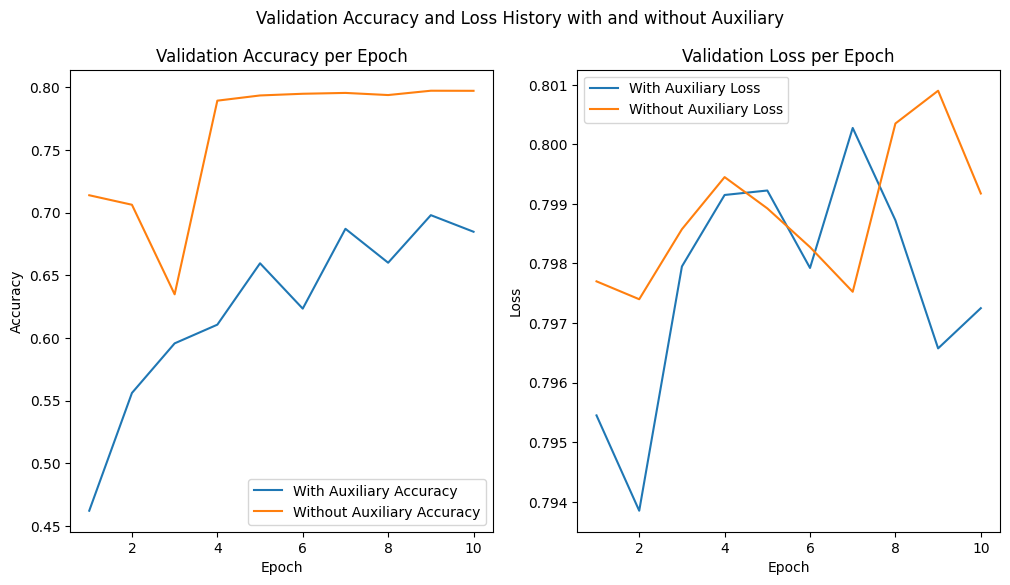

In [14]:
# Define everything that need for training
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

# Train the model with auxiliary classifiers
model_auxiliary, val_acc_history_auxiliary = train_model(model, dataloaders, criterion, optimizer, epochs, use_auxiliary=True)

# Train the model without auxiliary classifiers
model_no_auxiliary, val_acc_history_no_auxiliary = train_model(model, dataloaders, criterion, optimizer, epochs, use_auxiliary=False)

# Combine the training results
combined_val_acc_history = {'With Auxiliary Accuracy': val_acc_history_auxiliary,
                            'Without Auxiliary Accuracy': val_acc_history_no_auxiliary}

combined_history_auxiliary = train_model(model_auxiliary, dataloaders, criterion, optimizer, epochs, use_auxiliary=True)[1]
combined_history_no_auxiliary = train_model(model_no_auxiliary, dataloaders, criterion, optimizer, epochs, use_auxiliary=False)[1]

# Plot the training history for both models
plot_training_history({'With Auxiliary Accuracy': combined_val_acc_history['With Auxiliary Accuracy'],
                      'Without Auxiliary Accuracy': combined_val_acc_history['Without Auxiliary Accuracy'],
                      'With Auxiliary Loss': combined_history_auxiliary,
                      'Without Auxiliary Loss': combined_history_no_auxiliary},
                      'Validation Accuracy and Loss History with and without Auxiliary')